# Statistical foundations of Machine Learning

# Project: House Prices: Advanced Regression Techniques

Author: Arnau Dillen - arnau.dillen@vub.be - 0509766

## Abstract

In this paper we will consider several techniques to train a model that predicts house prices based on several variables. Before we start working with our data we preprocess it to account for missing values and categorical variables. We then reduce the amount of features with Principal Component Analysis, leaving us with a relatively small subset of principal components. To select an appropriate model for the data we try a linear approach, a decision tree and a neural network model. We select the best model based on the cross validation score. Finally we combine the best variant of each model type into a better performing ensemble model that takes a linear combination of the single model predictions. This model is trained on the provided training data set and consequently used to make predictions for the test data set. 

## Introduction


We will consider approaches that allow us to reduce features and select a model for the problem at hand. In the first section we perform Principal Component Analysis (PCA) on our set of features. This results in a new set of uncorrelated principal components that are a linear combination of the original variables. 

Before we can perform PCA we need to preprocess our data. The code below is responsible for this. We import all required data, libraries and scripts and then start by removing all categorical variables. We then replace missing NA values with the mean value of the data for this feature. As a final step we add the categorical variables as numerical values again by using a one-hot-encoding that turns all possible categorical values into features. The value of those features is then 1 or 0 depending wether the observation belongs to this category or not.

In [128]:
#Import libraries for tested models
library(nnet)
library(rpart) 
library(dummies)
library(xtable)

#Import required scripts
source("./code/utils.r")
source("./code/cross_validation.r")

set.seed(2)
options(warn=-1)

#Import data  (and set working directory if necessary)
#setwd("C:/Users/arnau/Documents/School/Projecten 16_17/Statistical_Foundations_ML/StatisticalML")
data.train<-read.csv("./data/train.csv")
data.test<-read.csv("./data/test.csv")

#Remove categorical variables
factor_variables<-which(sapply(data.train[1,],class)=="factor")
data_preprocessed.train<-data.train[,-factor_variables]

#Replace NA values with the variable mean
data_preprocessed.train<-data.frame(apply(data_preprocessed.train,2,replace_na_with_mean_value))

#Add categorical variables again with one-hot-encoding
data_factor.train<-data.train[,factor_variables]

data_factor_onehot.train <- dummy.data.frame(data_factor.train)

data_preprocessed.train<-cbind(data_preprocessed.train, data_factor_onehot.train)


X.train <- data_preprocessed.train[,setdiff(colnames(data_preprocessed.train), "SalePrice")]
Y.train <- data_preprocessed.train[,"SalePrice"]
print(paste("Number of features after preprocessing and one-hot-encoding: ", ncol(X.train)))

[1] "Number of features after preprocessing and one-hot-encoding:  305"


Preprocessing of the data as such results in 305 features. This is a huge amount of features that is way too large to be able to train a good model on. In the following section we discuss how we perform PCA and use the resulting components to reduce the amount of features.

In the section after this we detail the method that was used to select an appropriate model. We consider linear, decision tree and neural network models here and decide on the chosen model with a winner-takes-all approach.

The section after this will detail how we combine the best performing of each type of model into one ensemble model through stacked regression. The final model we get from this is then used to predict the house prices based on the provided test data set. 

We conclude this paper with a discussion of our results and propose possible improvements that can be made that might produce better results.

## Feature selection

To extract only a subset of the most relevant feature we chose to perform Principal Component Analysis (PCA). This technique consists of transforming our data in a lower dimentional space by creating a new set of axes called Principal Components, which are a linear combination of our data as such:
$$Z_1 = a_1 x_1 + ... a_n x_n = a^T x$$
Where $Z_1$ is the first principal component that has the greatest variation for a chosen set of values of $a_n$. The $x_n$ represent the original axes.


The second principal component is orthogonal with the first and represents the set of $a_n$ that result in the second most variance. This goes on for all other principal components until $k<=N$ where k is the number of principal component and N the number of original features. This results in all our principal components being uncorrelated.

In R we call the prcomp function which performs pca for us and plot the first 10 principal components against the variance they account for. Note that we set the scale variable to true. This will scale all our data to have mean 0 and variance 1, which is essential because of our one-hot-encoded features. First we look at the proportion of variance for each principal component.

[1] "Proportion of variance of principal components: "


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC296,PC297,PC298,PC299,PC300,PC301,PC302,PC303,PC304,PC305
Standard deviation,4.38880,2.981634,2.73449,2.638084,2.429539,2.297657,2.148512,2.142019,1.94457,1.883678,...,5.055038e-16,4.253383e-16,3.801672e-16,2.910073e-16,2.910073e-16,2.910073e-16,2.510453e-16,2.288315e-16,1.964118e-16,1.148166e-16
Proportion of Variance,0.06315,0.029150,0.02452,0.022820,0.019350,0.017310,0.015130,0.015040,0.01240,0.011630,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Cumulative Proportion,0.06315,0.092300,0.11682,0.139630,0.158990,0.176300,0.191430,0.206470,0.21887,0.230510,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


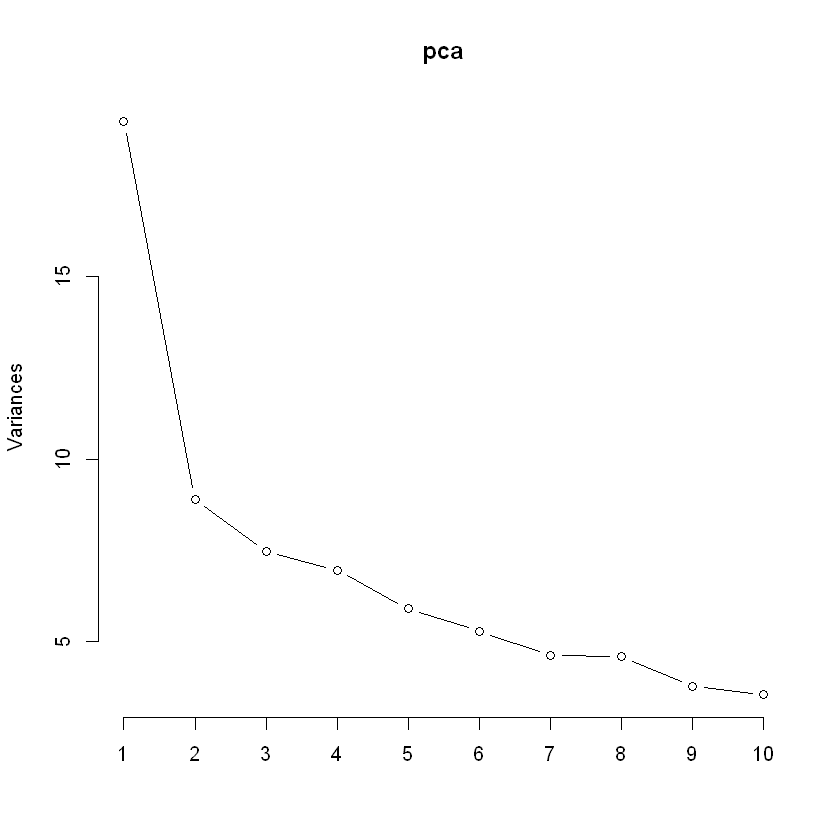

In [129]:
pca<-prcomp(X.train, retx=T, scale=T)

plot(pca, type="l")
pca_summary<-summary(pca)
print("Proportion of variance of principal components: ")
xtable(pca_summary$importance)#["Proportion of Variance",])

From the table above we can see that the first few principal components only account for part of the variance. We also see from the plot of the variance of the first 10 principal components that the variance quickly diminishes for the first few principal components. We decide to follow the convention of selecting the first few principal components that account for  95% of the variance in our data.

In [130]:
#Exract index of principal component with cummulative variance larger than 0.95
full_variance<-which(0.95 <= pca_summary$importance["Cumulative Proportion",])[1]
X_pca <- data.frame(pca$x[,1:full_variance])
print(paste("Remaining components: ", ncol(X_pca)))

[1] "Remaining components:  184"


This leaves us with the first 184 components remaining. 


This is still too many features, even more than our original set of features. We will now select our final features by cross-validating a linear regression model for a certain number of components used to describe our data. We will eliminate further componenst that do not result in any significan improvement for the cross-vailidation error or standard deviation.   

In [131]:


feature_crosval <- NULL #
stdev_crosval <-NULL

for (n_features in 2:ncol(X_pca)){
    X_sel <- X_pca[,1:n_features,drop=F]
    cv_err <- crossval_lm(X_sel, Y.train)
    feature_crosval <- c(feature_crosval, mean(cv_err))
    stdev_crosval <- c(stdev_crosval, sd(cv_err))
}
pca_crossval<-cbind(1:length(feature_crosval), feature_crosval,stdev_crosval)
xtable(na.omit(pca_crossval), label="Cross validation for number of features", auto=T)



V1,feature_crosval,stdev_crosval
1,0.2421477,0.02625138
2,0.2365890,0.02087784
3,0.1856436,0.02677183
4,0.1854844,0.02657503
5,0.1878371,0.02773665
6,0.1868716,0.02867750
7,0.1789030,0.03071568
8,0.1826118,0.02957058
9,0.1842157,0.02752281
13,0.1697913,0.02256872


In this table we see that the cross validating score improves at first when adding more principal components. But when using the first 10, 11 and 12 principal component we get Nan and NA values for our CV error and Standard deviation respectively. This is due to the linear model producing negative estimates resulting in a NaN value when taking the logarith of the prediction for cross validation. Because of this we also can not calculate the standard deviation. All table rows containing NA values have been removed from the above table for clarity's sake. Here we see that using the 25 first principal components results in both the lowes CV error and lowest standard deviation of the error. Based on these results we decide to to use the 25 first principal components as features for our further expeiments.

In [132]:
X.train <- X_pca[,1:25,drop=F]

## Model selection

For our model selection we test three different types of models and perform 10-fold cross-validation to evaluate the results.

First we try a polynomial model that consists of a linear combination of linear $\textit{lm}$ models. We tune this model with the degree $\textbf{m}$ of the polynomial. This approach was chosen for it's simplicity and because it already performed fairly well for the cross-validation of our peincipal components.

The next model we test is a decision tree using the $\textbf{rpart}$ package. After a tree is fitted it is pruned and cross validation results are computed for the two generated trees. This is an entierly different approach than a linear model. We chose it for this reason and to compare it's performance for principal components.

Finally we will try a neural network model with the $\textit{nnet}$ library. We try out different breadths of the hidden layer and select the best performing fit. We chose this model because it is currently one of the most popular ML approaches and was able to perform well on many regression and classification task. It also lets us compare a more complex model with the simple linear regression one.

Cross validation is used as an estimator of the MISE prediction error in all cases. 

We start by fitting a linear model with increasing polynomial degree.

In [164]:
#Models: Linear, Tree, NeuralNetwork
crossval_folds<-10 #10-fold cross-validation

#Linear models
max_pol_deg<-15

lm_es<-matrix(nrow=3, ncol=max_pol_deg+1)

lm_es[1,1]<-"Order"
lm_es[2,1]<-"CV Error"
lm_es[3,1]<-"Std Dev"
for (deg in 1:max_pol_deg){
    cv_error<-crossval_pol(X.train, Y.train, n_folds=crossval_folds, degree=deg)
    lm_es[1,deg+1]<-deg
    lm_es[2,deg+1]<-mean(cv_error)
    lm_es[3,deg+1]<-sd(cv_error)
}
xtable(lm_es)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Order,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
CV Error,0.17403315937749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Std Dev,0.0239773916437412,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Looking at the resulting table it seems that only a first order polynomial can be used when training a linear model on our principal components. All higher order polynomials result in NaN CV error due to them predicting negative house prices. We can clearly see that a polynomial model is not reliable in this situation.

We now plot the resulting linear model trained on the whole training data set.

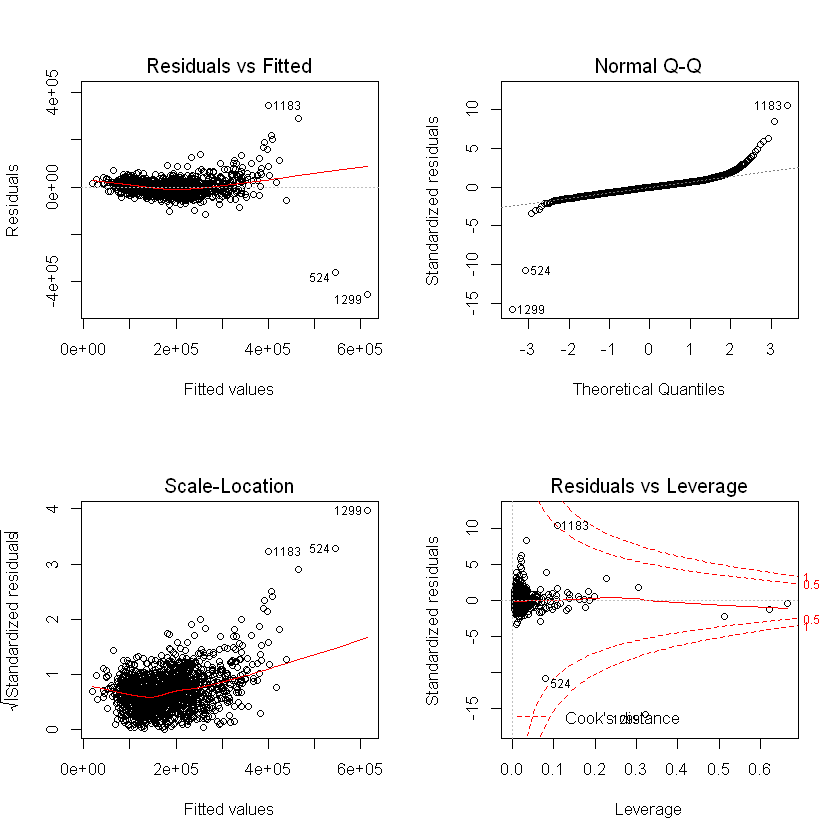

In [193]:
lm_data <- cbind(X.train,sale_price=Y.train)

lm_model<-lm(sale_price~., lm_data)
par(mfrow=c(2,2))
plot(lm_model)

The linear model seems to fit the transformed data relatively well. There seem to be outliers that do not fit very well, but most residuals are within the accepted limit and seem almost perfectly normally distributed according to the QQ-plot.

We now try to fit a decision tree model on our transformed data.

In [103]:
#Decision tree
tree_es<-matrix(nrow=3, ncol=3)

cv_tree<-crossval_tree(X.train, Y.train, n_folds=crossval_folds)

tree_es[1,1]<-" "
tree_es[2,1]<-"Original fit"
tree_es[3,1]<-"Pruned"
tree_es[1,2]<-"CV Error"
tree_es[1,3]<-"Std Dev"
tree_es[2,2]<-mean(cv_tree[1,])
tree_es[2,3]<-sd(cv_tree[1,])
tree_es[3,2]<-mean(cv_tree[2,])
tree_es[3,3]<-sd(cv_tree[2,])
xtable(tree_es)

1,2,3
,CV Error,Std Dev
Original fit,0.207057446493887,0.0175938015678106
Pruned,0.207793501721271,0.0194306924742303


We can see that pruning actually makes our predictions slightly worse. We will not prune the tree and use the following tree that is fitted to our training data.

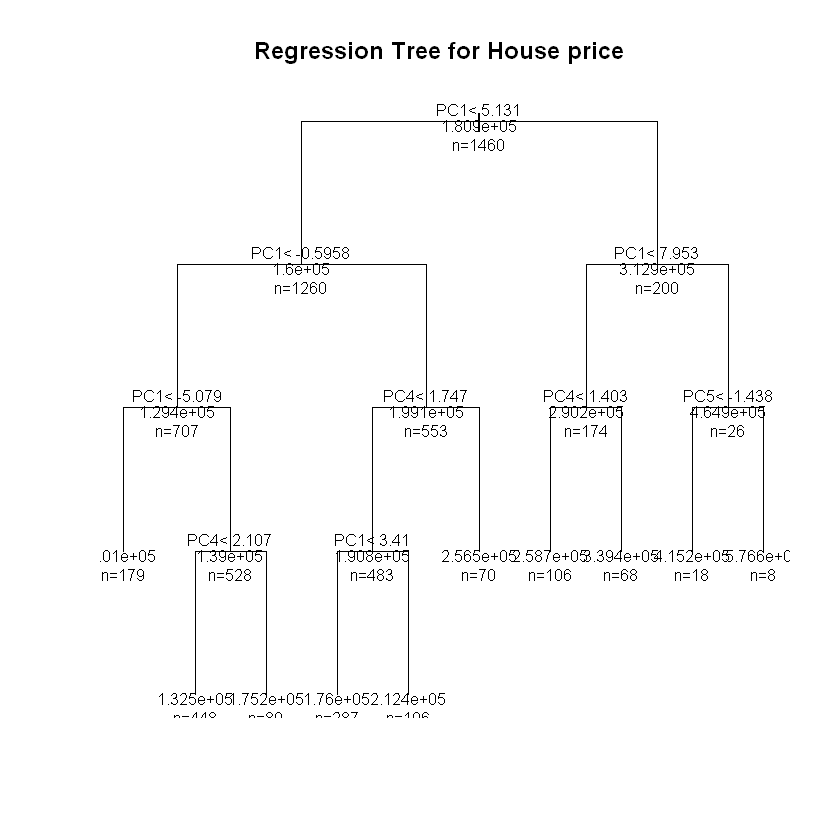

In [104]:
ds<-cbind(X.train, sale_price=Y.train)
#Fit tree
tree_fit<-rpart(sale_price~., method="anova", data=ds)
plot(tree_fit, uniform=TRUE, main="Regression Tree for House price ")
text(tree_fit, use.n=TRUE, all=TRUE, cex=.8)

Finally we try to fit our neural network with different amounts of hidden nodes in the hidden layer.

In [105]:
#Neural network
max_nodes<-30

nn_es<-matrix(nrow=2, ncol=max_nodes)

for (nodes in 1:max_nodes){
    cv_error<-crossval_nn(X.train, Y.train, n_folds=crossval_folds, size=nodes )
    nn_es[1,nodes]<-mean(cv_error)
    nn_es[2,nodes]<-sd(cv_error)
    cv_error
}

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.30088854,0.28335493,0.27995834,0.27781949,0.26620732,0.26551784,0.26417695,0.2653624,0.26156510,0.25855903,0.2579653,0.26447974,0.25995129,0.25950025,0.2558104
0.02392192,0.01608414,0.01828814,0.02377481,0.02412014,0.01701351,0.02226098,0.0316822,0.02611617,0.01709182,0.0248543,0.02206732,0.02802188,0.02327709,0.0186765


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.26107333,0.2580198,0.25088644,0.25146967,0.2507954,0.25006486,0.24656633,0.25890094,0.25175903,0.25645020,0.25885693,0.25525156,0.24313384,0.25968965,0.2448537
0.02075322,0.0145448,0.02461277,0.02478543,0.0205725,0.02145665,0.01970367,0.02151471,0.01760236,0.02501768,0.02118087,0.02407142,0.01340983,0.03055254,0.0280942


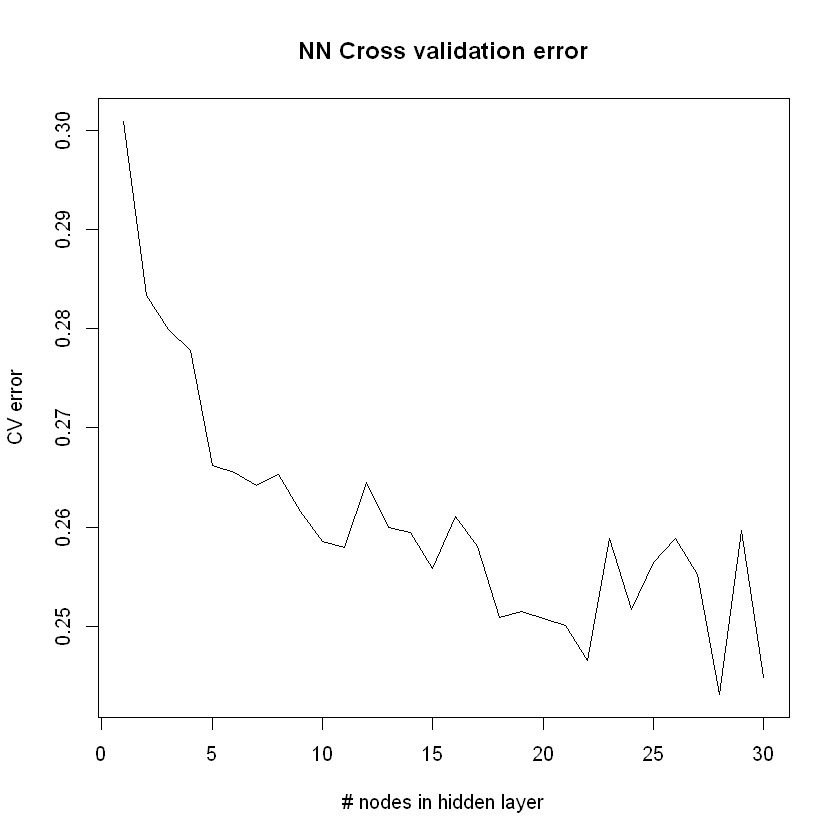

In [106]:

xtable(nn_es[,1:15])
xtable(nn_es[,16:30])
plot(1:30, nn_es[1,], main="NN Cross validation error", xlab="# nodes in hidden layer", ylab="CV error", type="l")

The best performing neural network seems to be the one with 25 nodes in the hidden layer, that is the same amount of hidden nodes as input nodes. We can also see that even the best neural network model performs worse than the other models. The standard deviation of the error is only slightly better than that of the linear model, which is not significan given the difference in mean. Note that this result ca vary when retraining the model.

The final neural network with 25 nodes in the hidden layer, trained on all data looks like this

SHA-1 hash of file is 74c80bd5ddbc17ab3ae5ece9c0ed9beb612e87ef
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required package: reshape
Loading required pa

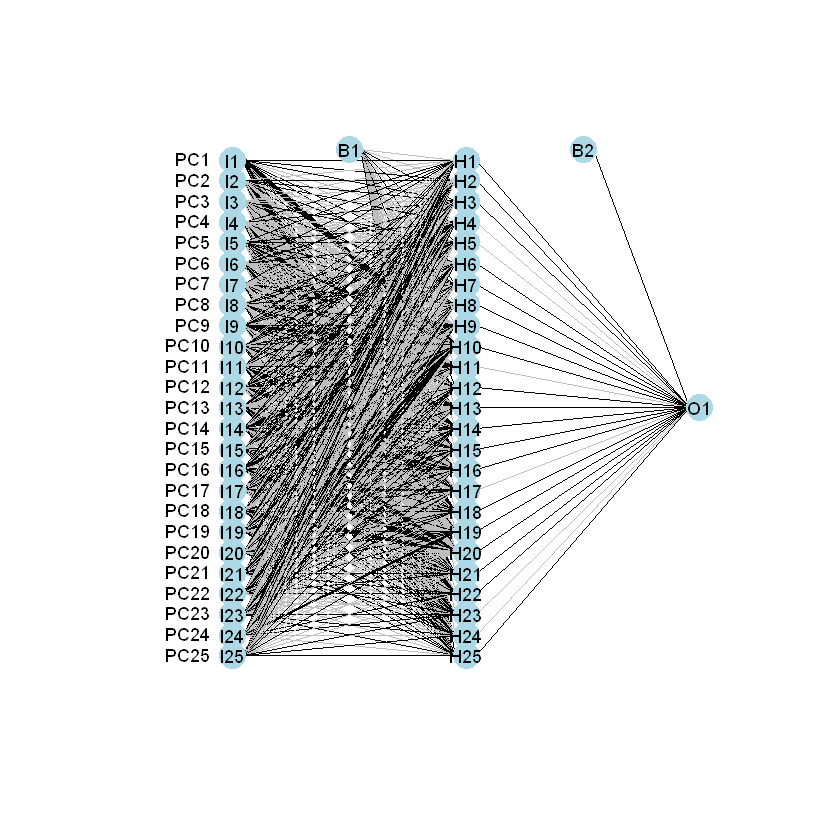

In [122]:
nnet_fit<-nnet(X.train, Y.train, size=25, maxit=1000, trace=FALSE, linout=TRUE)
options(width=130)
#import the plot function from Github
library(devtools)
source_url('https://gist.githubusercontent.com/fawda123/7471137/raw/466c1474d0a505ff044412703516c34f1a4684a5/nnet_plot_update.r')
plot.nnet(nnet_fit, circle.cex=3, cex=0.9)

Applying a winner-takes-all criterion, we conclude that the simple linear model is the best when using the 25 first principal components as features.

## Ensemble techniques

For our ensemble technique we chose to implement the Stacked regression algorithm. It allows us to produce a linear combination of the model predictions with the following formula. 
$$ \sum_{j=1}^m \hat{\beta_j} h_j(x)$$
Where $\hat{\beta_j}$ are weights and $h_j(x)$ are single model predictions. To find the weights $\hat{\beta_j}$ we need to assess how well our estimators contribute to a prediction. For this purpose we perform a leave-one-out estimate for every sample with every model. This results in a dataset of estimates $h_j(x_i, \alpha_N^{(-i)})$ 
for model $\textit{j}$ on the $\textit{i}$th training sample. If we now perform a least-squares regression on this data, we can obtain the parameters for each model   

We start by computing the leave-one-out estimates for each of our three chosen models, the simple linear model, the tree that is not pruned, and a neural network with 25 nodes in the hidden layer.

In [124]:
nn_estimates<-loo_estimates_nn(X.train,Y.train, size=25)
pol_estimates<-loo_estimates_pol(X.train, Y.train)
tree_estimates<-loo_estimates_tree(X.train,Y.train, prune=FALSE)

This process is quite computationally intensive and takes some time to compute. However, now we can perform a linear regression to identify the best parameters for our ensemble estimator. We chose to perform ridge regression because the different model predictions are strongly correlated since they predict the same value.

In [161]:
library(MASS)
params<-lm.ridge(Y.train~nn_estimates+pol_estimates+tree_estimates)
params

                 nn_estimates  pol_estimates tree_estimates 
 -6406.0188366      0.1007773      0.5133222      0.4207715 

Unsurprisingly the neural network gets the least weight as it performed the worst on our data. The linear model accounts for more than 50% of the predicted value. This confirms our findings in the previous section again. We now cross-validate the ensemble model with the computed weights. 

In [169]:
#Weights: Linear, Tree, NN
ensemble_weights<-c(0.5133222, 0.4207715, 0.1007773)
ensemble_cv<-crossval_ensemble(X.train, Y.train, ensemble_weights, nn_size=25)
print(paste("CV error: ", mean(ensemble_cv)))
print(paste("Std Dev: ", sd(ensemble_cv)))

[1] "CV error:  0.168823851120033"
[1] "Std Dev:  0.0227431088651212"


This ensemble model results in a slight decrease of the cross-validation error. The standard deviation of this error is similar to that of the linear model. It seems to predict relatively consistently. We choose this as our final model. 

## Conclusion

To predict the sale price of houses according to a set of both numerical and categorical attributes we tested out several models. Before we could start training a model we had to preprocess our data to be able to work with categorical features. We chose to encode factor variables with a one-hot-encoding, but this resulted in way too many features to be able to train an accurate model with. To solve this we had to select only those features that are most relevant. 

As a feature selectuion procedure we performed principal component analysis. By selecting only the first components as to cummulatively account for 95% of the variance in our data. This significantly decreased the amount of features, but we still had more than 180 remaining features. Therefore we decided to cross-validate a linear model fitted with increasing amount of features to identify at which amount of principal comoponents there is no more ipmrovement in the cross-validation error and the standard deviation of this error. We decided to only use the 25 first principal components to train our model on.

We decided to take a winner-takes-all approach, based on the cross-validation error, to identify which of our chosen models performed the best. We tested three distict types of models. 

First we fitted and cross-validated a linear model with increasing polynomial degree. We came to the constatation that only the simple first degree function was a reliable predictor for our data. This is not surprising since we are working with principal components that are already a linear combination of the original features and are orthogonal and therefore uncorrelated.

The next model we fitted was a decision tree. The parametric identification procedure for this model simply consists of fitting a tree, pruning it and evaluating if the pruned tree can perform better. There was almost no difference between the pruned and non-pruned tree errors, the pruned tree even performed slightly worse. The decsion tree does not perform better than our previous linear model for cross-validation error, but does have a smaller standard devation. This does not matter however, as the linear model still performs better. The decision tree would probably have performed better had it not been trained on the principal components, or on a different set of principal components. The nature of decision trees would also have allowed us to work with the categorical variables without having to one-hot-encode them. A random forest approach would probably give us even better results, but there was regrettably no time left to implement this approach.

We also trained a neural network on our data. To find the ideal amount of nodes in the hidden layer of the network we trained several networks with increasing amount of nodes. We finally selected the network with the best cross-validation error, namely one with 25 nodes in it's hidden layer. This newtork however did not perform better than the other models. It actually performed worse in comparison with the tree model than the tree model compared to the linear model. This is probably due to the fact that we use principal components as features again. As there is no correlation between components and neural networks are a complex model. A different type of feature selection might be better suited for neural networks. The accuracy can probably also be improved by investigating different types of network architectures and activation functions. 

Finally we implemented an ensemble model. This model combines the predictions of the best variants for our three models. The predictions of the chosen models are linearily combined with each single prediction being multiplied by a chosen weight. To decide on the weight values for each model we performed stacked regression. This approach is however computationally expensive as it has to compute leave-one-out predictions for every model. It did however result in slightly better performance. It seems that even though the other models perform worse, they contibute positively to the final prediction quality of the ensemble model.

In conclusion we can say that performing PCA and fitting a linear model to our data performs relatively well. The other models we tested seem less suited, but could result in better performance with a different feature selection approach and more advanced optimizations. We will now present our predictions for the test data set.

## Test set predictions

In [176]:
#Preprocess test data
factor_variables<-which(sapply(data.test[1,],class)=="factor")
data_preprocessed.test<-data.test[,-factor_variables]

#Replace NA values with the variable mean
data_preprocessed.test<-data.frame(apply(data_preprocessed.test,2,replace_na_with_mean_value))

#Add categorical variables again with one-hot-encoding
data_factor.test<-data.test[,factor_variables]
data_factor_onehot.test <- dummy.data.frame(data_factor.test)

data_preprocessed.test<-cbind(data_preprocessed.test, data_factor_onehot.test)

#Transform test data to principal comoponents
test_pca <- data.frame(prcomp(data_preprocessed.test, retx=T, scale=T)$x[,1:full_variance])
final_data<-cbind(X.train, sale_price=Y.train)
#Fit models
tree<-rpart(sale_price~., method="anova", data=final_data)
linear<-lm(sale_price~., final_data)
nn<-nnet(X.train, Y.train, size=25, maxit=1000, trace=FALSE, linout=TRUE)
#predict
predictions<-ensemble_weights[1]*predict(linear, test_pca) + ensemble_weights[2]*predict(tree, test_pca) + ensemble_weights[3]*predict(nn, test_pca)


In [190]:
format_pred<-data.frame(predictions)
names(format_pred)[names(format_pred)=="predictions"] <- "SalePrice"
format_pred<-cbind(Id=1461:2919, format_pred)
write.csv(format_pred, file="./data/Predictions.csv", row.names=FALSE)

In [194]:
format_pred

Id,SalePrice
1461,228963.245
1462,175392.846
1463,172543.702
1464,139642.929
1465,142575.303
1466,190413.486
1467,185295.314
1468,179256.499
1469,149757.816
1470,222983.219
